# DATA ANALYSIS (3.5)


This notebook investigates the impact of **hero selection**, **role swapping**, and gameplay strategies on win rates in a competitive gaming environment. By analyzing player performance metrics, hero roles, and swapping behaviors, the study aims to uncover patterns and correlations that influence match outcomes. 

***

In [79]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import warnings

warnings.filterwarnings('ignore', category=DeprecationWarning)
pd.options.mode.chained_assignment = None

In [ ]:
# Load the CSV file
ihsc_df = pd.read_csv('individual_hero_stats_combined.csv')
heroes_df = pd.read_csv('hero_info.csv')
ihsc_df = ihsc_df.merge(heroes_df[['id', 'name']], left_on='hero_id_x', right_on='id', how='left', suffixes=('', '_hero'))

In [26]:
# Calculate winrate for each hero

# Group by hero_id_x and aggregate statistics
hero_stats = ihsc_df.groupby('hero_id_x').agg({
    'kills_x': ['mean', 'sum', 'max'],
    'deaths_x': ['mean', 'sum', 'max'],
    'assists_x': ['mean', 'sum', 'max'],
    'hit_rate': ['mean', 'max'],
    'playtime.raw': ['mean', 'sum']
}).reset_index()



# Flatten multi-level columns
hero_stats.columns = ['hero_id_x', 'avg_kills', 'total_kills', 'max_kills',
                      'avg_deaths', 'total_deaths', 'max_deaths',
                      'avg_assists', 'total_assists', 'max_assists',
                      'avg_hit_rate', 'max_hit_rate',
                      'avg_playtime', 'total_playtime']

# Merge with hero names for labeling
hero_stats = hero_stats.merge(heroes_df[['id', 'role','name']], left_on='hero_id_x', right_on='id', how='left')

# Drop unnecessary columns
hero_stats = hero_stats.drop(columns=['id'])

# add winrate
winrate = ihsc_df.groupby('hero_id_x')['is_win'].mean().reset_index()
winrate.columns = ['hero_id_x', 'win_rate']

hero_stats = hero_stats.merge(winrate, on='hero_id_x', how='left')

# Display the resulting DataFrame
# hero_stats.head()

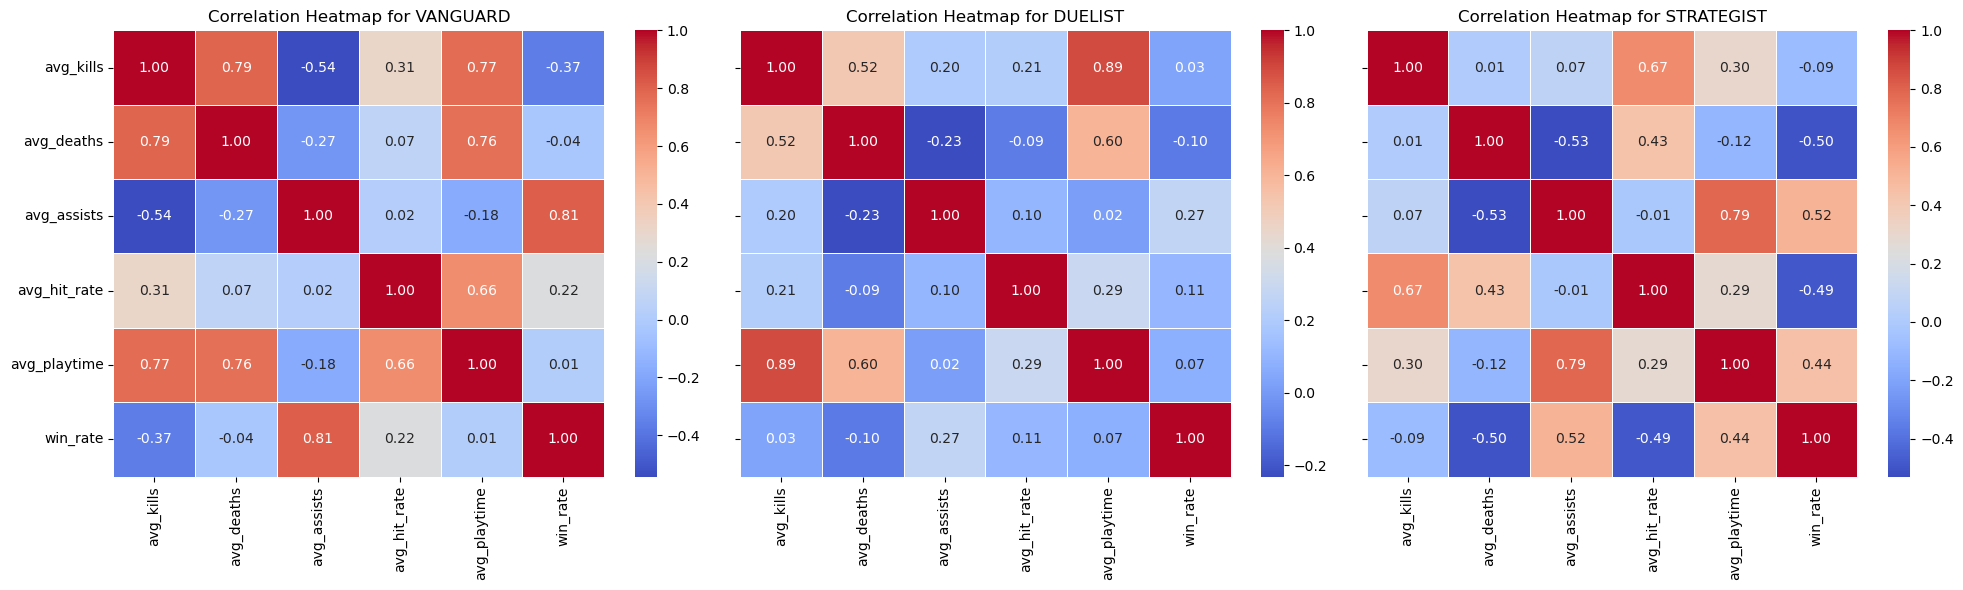

In [25]:
# Define roles to plot
roles = hero_stats['role'].unique()

# Create subplots
fig, axes = plt.subplots(1, 3, figsize=(20, 6), sharey=True)

# Loop through each role and plot the heatmap
for ax, role in zip(axes, roles):
    # Filter data for the role
    role_data = hero_stats[hero_stats['role'] == role]
    
    # Select numerical columns for the heatmap
    numerical_columns = ['avg_kills', 'avg_deaths', 'avg_assists', 'avg_hit_rate', 'avg_playtime', 'win_rate']
    correlation_matrix = role_data[numerical_columns].corr()
    
    # Plot the heatmap
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5, ax=ax)
    ax.set_title(f'Correlation Heatmap for {role}')

plt.tight_layout()
plt.show()

The correlation matrix in context with `Analysis 3`(*that **STRATEGISTs** are the most impactful role in winning*) suggests swapping supports mid-match--causing an overall lower avg_playtime--lower's your overall chance of winning. 

A negative relationship with `hit-rate` and `win-rate` further emphasizes the impact of the role likely due to ultimate (ult) usage and resource management. We can see trends we understand to be true as well, such as `avg_kills` and `avg_hit_rate` increasing as the time spent on the character increases.  

Let's take a look at whether or not players who played multiple characters in a match lost more to confirm this hypothesis.

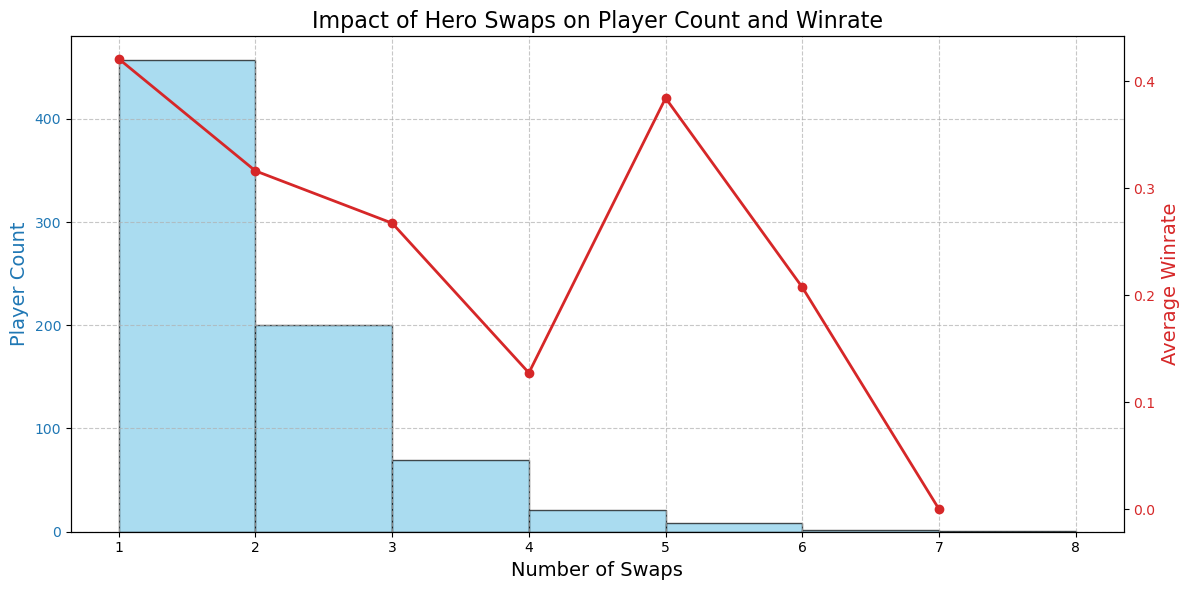

In [78]:
# Group by match_uid and player_uid, and count unique hero_id_x values
player_hero_counts = ihsc_df.groupby(['match_uid', 'player_uid'])['hero_id_x'].nunique().reset_index()

# Filter players who played multiple heroes in a single match
multi_hero_players = player_hero_counts[player_hero_counts['hero_id_x'] > 1]

# Calculate the number of swaps (unique heroes - 1)
multi_hero_players['swaps'] = multi_hero_players['hero_id_x'] - 1

# Count the number of unique players and total swaps
unique_players_count = multi_hero_players['player_uid'].nunique()
total_swaps = multi_hero_players['swaps'].sum()

# Merge multi_hero_players with ihsc_df to get winrate for each player
player_winrate = ihsc_df.groupby('player_uid')['is_win'].mean().reset_index()
player_winrate.columns = ['player_uid', 'win_rate']

# Merge the winrate with multi_hero_players
multi_hero_players = multi_hero_players.merge(player_winrate, on='player_uid', how='left')

# Plot swaps distribution and its impact on winrate
fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot histogram of swaps
color = 'skyblue'
ax1.set_xlabel('Number of Swaps', fontsize=14)
ax1.set_ylabel('Player Count', color='tab:blue', fontsize=14)
ax1.hist(multi_hero_players['swaps'], bins=range(1, multi_hero_players['swaps'].max() + 2), alpha=0.7, color=color, edgecolor='black')
ax1.tick_params(axis='y', labelcolor='tab:blue')
ax1.grid(True, linestyle='--', alpha=0.7)

# Create a twin y-axis to plot winrate
ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel('Average Winrate', color=color, fontsize=14)
average_winrate_by_swaps = multi_hero_players.groupby('swaps')['win_rate'].mean()
ax2.plot(average_winrate_by_swaps.index, average_winrate_by_swaps.values, color=color, marker='o', linestyle='-', linewidth=2)
ax2.tick_params(axis='y', labelcolor=color)

# Add title and layout adjustments
plt.title('Impact of Hero Swaps on Player Count and Winrate', fontsize=16)
fig.tight_layout()
plt.show()



In [80]:
# Include hero swaps within the same role
# Group by match_uid and player_uid to track hero swaps
swaps_df = ihsc_df.sort_values(by=['match_uid', 'player_uid', 'playtime.raw']).groupby(['match_uid', 'player_uid'])

# Create a new DataFrame to track swaps
role_swaps = swaps_df.apply(lambda group: pd.DataFrame({
    'match_uid': group['match_uid'],
    'player_uid': group['player_uid'],
    'role_from': group['role'].shift(),
    'role_to': group['role']
})).reset_index(drop=True)

# Filter rows where a swap occurred (role_from is not NaN)
role_swaps = role_swaps.dropna(subset=['role_from', 'role_to'])

# Count the number of swaps per player per match
role_swaps['swap_count'] = role_swaps.groupby(['match_uid', 'player_uid']).cumcount() + 1

# Display the resulting DataFrame
# role_swaps.head()

# Calculate the winrate for each swap type
swap_winrate = role_swaps.groupby(['role_from', 'role_to']).agg({
    'swap_count': 'count',
    'match_uid': 'nunique',
    'player_uid': 'nunique'
}).reset_index()

# Merge with winrate data
swap_winrate = swap_winrate.merge(
    role_swaps.groupby(['role_from', 'role_to'])['match_uid'].apply(
        lambda x: ihsc_df[ihsc_df['match_uid'].isin(x)]['is_win'].mean()
    ).reset_index(name='avg_win_rate'),
    on=['role_from', 'role_to'],
    how='left'
)

# Display the resulting DataFrame
# swap_winrate.head()

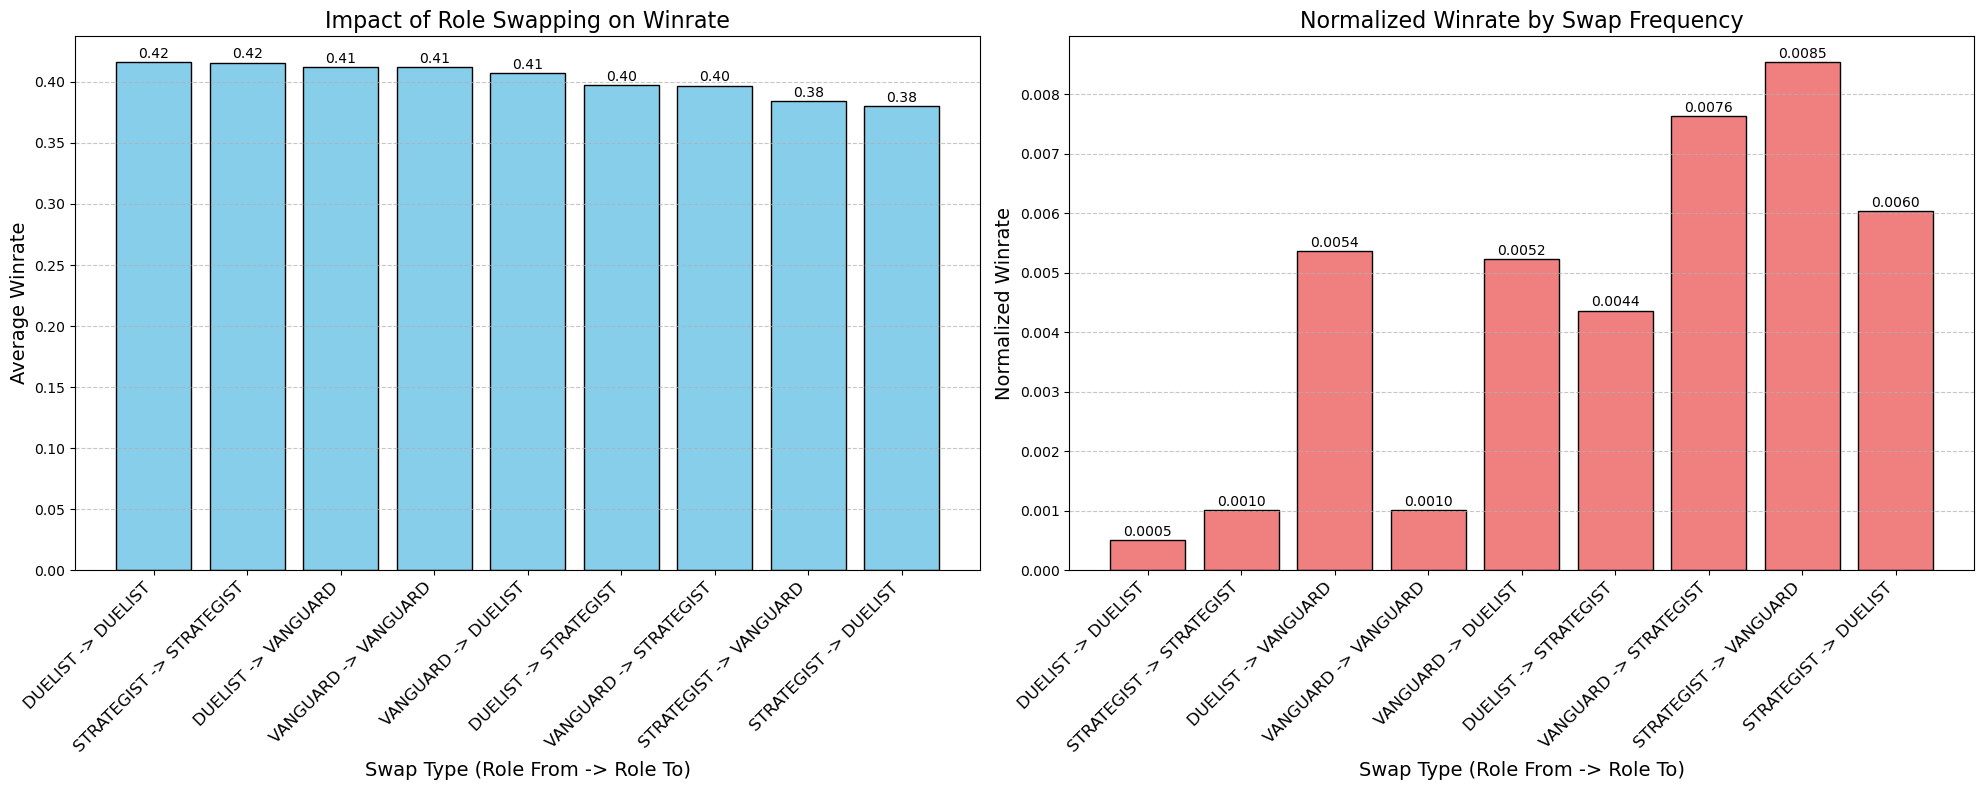

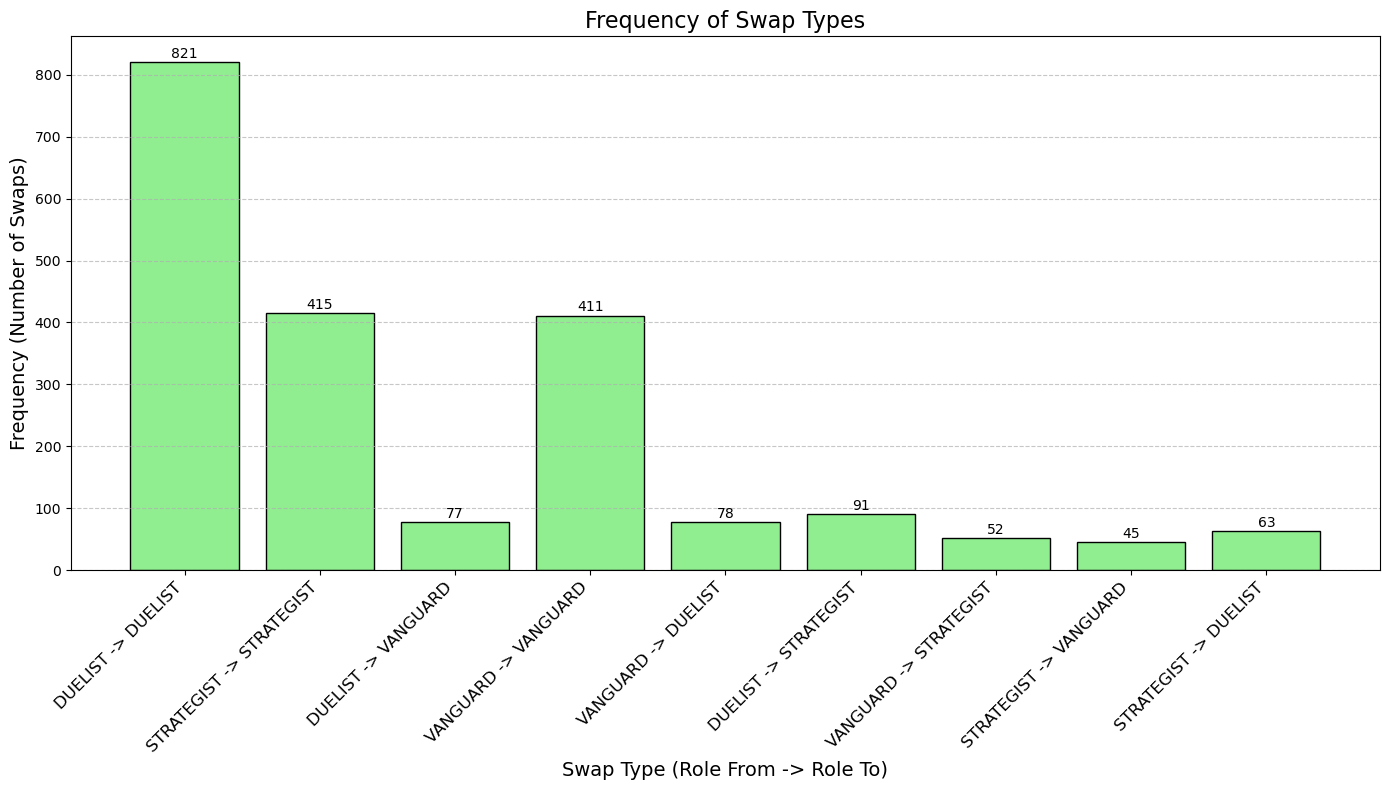

In [ ]:

# Sort swap_winrate by avg_win_rate for better visualization
swap_winrate_sorted = swap_winrate.sort_values(by='avg_win_rate', ascending=False)

# Create subplots for the bar charts
fig, axes = plt.subplots(1, 2, figsize=(20, 8))

# Left subplot: Original winrate bar chart
bars = axes[0].bar(swap_winrate_sorted['role_from'] + " -> " + swap_winrate_sorted['role_to'], 
                   swap_winrate_sorted['avg_win_rate'], 
                   color='skyblue', edgecolor='black')

# Add labels and title for the left subplot
axes[0].set_xlabel('Swap Type (Role From -> Role To)', fontsize=14)
axes[0].set_ylabel('Average Winrate', fontsize=14)
axes[0].set_title('Impact of Role Swapping on Winrate', fontsize=16)
axes[0].set_xticks(range(len(swap_winrate_sorted)))
axes[0].set_xticklabels(swap_winrate_sorted['role_from'] + " -> " + swap_winrate_sorted['role_to'], rotation=45, ha='right', fontsize=12)

# Annotate bars with winrate values
for bar in bars:
    height = bar.get_height()
    axes[0].annotate(f'{height:.2f}', xy=(bar.get_x() + bar.get_width() / 2, height),
                     xytext=(0, 3), textcoords="offset points", ha='center', fontsize=10)

# Add grid for better readability
axes[0].grid(axis='y', linestyle='--', alpha=0.7)

# Right subplot: Normalized winrate bar chart
swap_winrate_sorted['normalized_winrate'] = swap_winrate_sorted['avg_win_rate'] / swap_winrate_sorted['swap_count']
bars_normalized = axes[1].bar(swap_winrate_sorted['role_from'] + " -> " + swap_winrate_sorted['role_to'], 
                              swap_winrate_sorted['normalized_winrate'], 
                              color='lightcoral', edgecolor='black')

# Add labels and title for the right subplot
axes[1].set_xlabel('Swap Type (Role From -> Role To)', fontsize=14)
axes[1].set_ylabel('Normalized Winrate', fontsize=14)
axes[1].set_title('Normalized Winrate by Swap Frequency', fontsize=16)
axes[1].set_xticks(range(len(swap_winrate_sorted)))
axes[1].set_xticklabels(swap_winrate_sorted['role_from'] + " -> " + swap_winrate_sorted['role_to'], rotation=45, ha='right', fontsize=12)

# Annotate bars with normalized winrate values
for bar in bars_normalized:
    height = bar.get_height()
    axes[1].annotate(f'{height:.4f}', xy=(bar.get_x() + bar.get_width() / 2, height),
                     xytext=(0, 3), textcoords="offset points", ha='center', fontsize=10)

# Add grid for better readability
axes[1].grid(axis='y', linestyle='--', alpha=0.7)

# Adjust layout and show the plot
plt.tight_layout()
plt.show()

# Plot the frequency of swap types
plt.figure(figsize=(14, 8))
bars = plt.bar(swap_winrate_sorted['role_from'] + " -> " + swap_winrate_sorted['role_to'], 
               swap_winrate_sorted['swap_count'], 
               color='lightgreen', edgecolor='black')

# Add labels and title
plt.xlabel('Swap Type (Role From -> Role To)', fontsize=14)
plt.ylabel('Frequency (Number of Swaps)', fontsize=14)
plt.title('Frequency of Swap Types', fontsize=16)
plt.xticks(rotation=45, ha='right', fontsize=12)

# Annotate bars with swap counts
for bar in bars:
    height = bar.get_height()
    plt.annotate(f'{height}', xy=(bar.get_x() + bar.get_width() / 2, height),
                 xytext=(0, 3), textcoords="offset points", ha='center', fontsize=10)

# Add grid for better readability
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Adjust layout and show the plot
plt.tight_layout()
plt.show()

# **Switching Characters/Roles**

Overall, the larger number of swaps a player/team makes is associated with a negative winrate. Role swapping has a negative associated winrate fairly even accross the board, however, the lower winrate for **STRATEGIST** does suggest a large impact on game outcome. 

When normalizing the winrate on role swapping, the character swap (*e.g. **DUELIST -> DUELIST***) categories across all roles are significantly the lowest. This is likely due to team composition issues, *'one-trick'* players, lower profeciency at the hero at the same skill level, and or lack of hero kits in that role to deal with the enemy.

#### Lowest Win-rate Swap (Adjusted)

The lowest winrate swap after adjusting is **DUELIST -> STRATEGIST**. There are many implications can be drawn about this such as:
- **DUELISTs** on average understand less about supporting priority / ultimate economy
- **STRATEGISTs** were under-performing significantly, and the match was going to be lost regardless

As **STRATEGIST -> DUELIST** win rate remains larger, it suggests that **STRATEGISTs** aren't swapping to fill the role of DUELIST at the same rate, meaning it's likely a 2-1-3 or 1-2-3 comp being formed. We can see from the chart in **DATA ANALYSIS (3)**

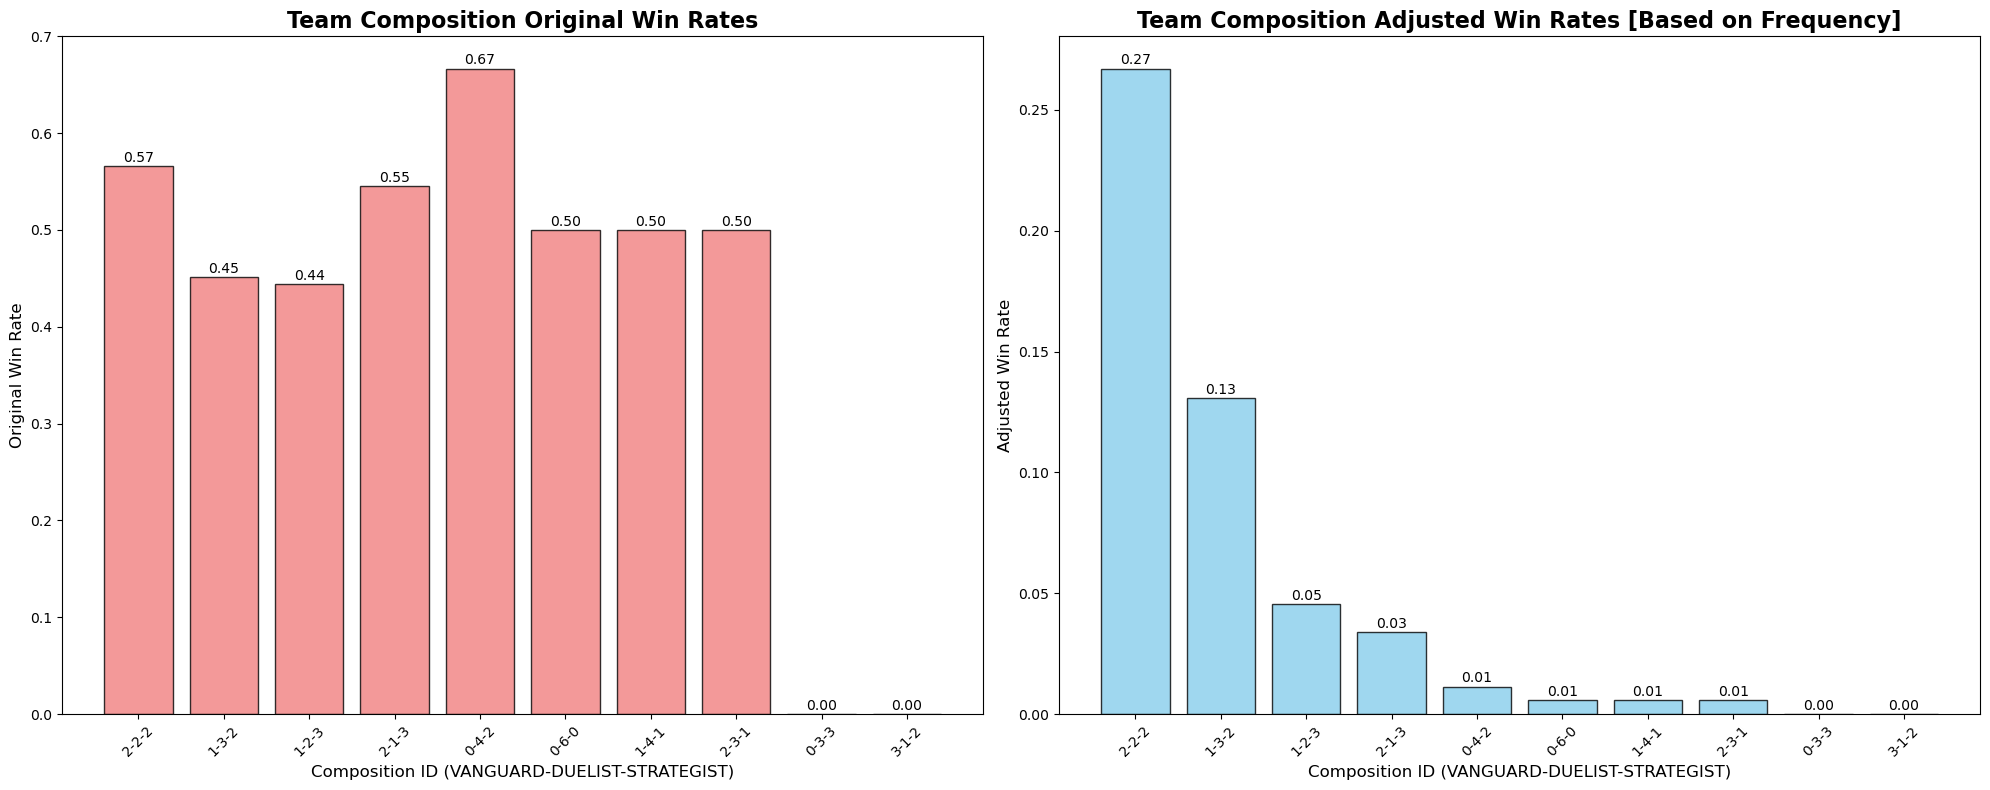

that these comps heavily underperform compared to the classic 2-2-2 that has been ideal since the start of Hero Shooters.

### **On Win-rate per Number of Swaps**

There is a noticable downwards trend in the number of swaps lowering the overall likelihood to win. However, we can see around 5 swaps in a match can actually improve your ability to win. Considering these are grouped by `match_uid`  and by teams that won, it can imply that team composition matters more than swapping itself. 

For example, 1-VANGUARD (Melee/Dive), 3-DUELISTs (1 Melee / 2 Projectile), 2-STRATEGISTS (1 Projectile / 1 Hitscan) has no necessary cohesion. If 5 members were to swap and fulfill a team identity (Brawl/Dive/Poke, etc.) around the member carrying on the team, or into a composition that counter's the enemy (Dive -> Poke), you would see a drastic increase in likelihood to win regardless of current performance score.  